In [23]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog

import sys

images = glob.glob('./imgdb/*/*/*.png')
cars = []
notcars = []

for image in images:

    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)

In [24]:
len(cars)

8792

In [25]:
len(notcars)

8968

In [26]:
def normalize_img(img):
    return (255 * img/np.max(img)).astype(np.uint8)
  

In [27]:
# when developing classifier, allow for shortening our dataset
# by setting this to smaller values, e.g. 100
NUM_CARS = len(cars)
NUM_NOTCARS = len(notcars)

ORIENT = 4
PIX_PER_CELL = 4
CELL_PER_BLOCK = 3
HOG_CHANNEL = 0

def get_hog_features(img, vis=False):
    return hog(img,
               orientations=ORIENT, 
               pixels_per_cell=(PIX_PER_CELL, PIX_PER_CELL),
               cells_per_block=(CELL_PER_BLOCK, CELL_PER_BLOCK), 
               transform_sqrt=False,
               visualise=vis, 
               feature_vector=True)
  


def get_imgs_and_features(source, ind):
    # Read in the image
    img = mpimg.imread(source[ind])
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    features, hog_img = get_hog_features(img[:,:,HOG_CHANNEL],
                            vis=True)
    
    return img, gray, hog_img, features

def get_features_only(filename):
    img = mpimg.imread(filename)
    return get_hog_features(img[:,:,HOG_CHANNEL], vis=False)

def make_mosaic():
    # get a few images of cars and non-cars, and stack them
    for name, source in [('mosaic_cars.png', cars), ('mosaic_noncars.png', notcars)]:
        grays = []
        hog_imgs = []
        for ind in range(20):
            img, gray, hog_img, features = get_imgs_and_features(source, ind)
            grays.append(normalize_img(gray))
            hog_imgs.append(normalize_img(hog_img))

        mosaic = np.vstack((np.hstack(grays), np.hstack(hog_imgs)))
        cv2.imwrite(name, mosaic)

        
make_mosaic()
    


In [28]:
# now build the training and testing sets
car_feats = [get_features_only(f) for f in cars[:NUM_CARS]]
notcar_feats = [get_features_only(f) for f in notcars[:NUM_NOTCARS]]
X = np.vstack((car_feats, notcar_feats))


In [29]:
from sklearn.preprocessing import StandardScaler

X = np.vstack((car_feats, notcar_feats)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(NUM_CARS), np.zeros(NUM_NOTCARS)))

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

X_train, X_test, y_train, y_test = train_test_split(
     scaled_X, y, test_size=0.2)

svc = LinearSVC()
svc.fit(X_train, y_train)

print("Training accuracy: ", svc.score(X_train, y_train))
print("Test accuracy: ", svc.score(X_test, y_test))

Training accuracy:  1.0
Test accuracy:  0.934403153153


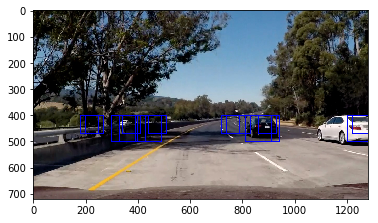

In [60]:
# Ok, time to slide those windows.
BOX_COLOR = (0,0,255)

%matplotlib inline
img = mpimg.imread('./test_images/test5.jpg')

box_templates = [
    (0, 400, 70, 20),
    (0, 400, 100, 30),
    (0, 450, 150, 50),
    (0, 500, 200, 70),
]
maxy, maxx, channels = np.shape(img)

def make_boxes():
    boxes = []
    for bt in box_templates:
        x0, y0, size, step = bt
        x, y = x0, y0
        while x < maxx:
            boxes.append(((x, y), (x + size, y+size)))
            x += step

    return boxes

boxes = make_boxes()

heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
HEAT_THRESH = 2
OVERLAP_THRESH = 1.4

cars_found = []

for p1, p2 in boxes:
    x1, y1 = p1
    x2, y2 = p2
    cropped = cv2.resize(img[y1:y2, x1:x2], (64, 64))
    ftr = get_hog_features(cropped[:,:,HOG_CHANNEL], vis=False)
    ftr = X_scaler.transform(np.array(ftr).reshape(1, -1))
    if svc.predict(ftr) == 1:
        cars_found.append((p1, p2))
        heatmap[y1:y2, x1:x2] += 1
        
heatmap[heatmap < HEAT_THRESH] = 0
heatmap = np.clip(heatmap, 0, 255)



for p1, p2 in cars_found:
    x1, y1 = p1
    x2, y2 = p2
    overlaps = np.sum(heatmap[y1:y2, x1:x2]).astype(np.float)
    area = (x2-x1)*(y2-y1)
    
    if overlaps / area > OVERLAP_THRESH:
        cv2.rectangle(img, p1, p2, BOX_COLOR, 2)

plt.imshow(cropped)
    


plt.imshow(img)